In [1]:
import math

# helper functions

# subgraph creation, bgpNetwork needs to be established and the provided asn value must be a STRING and present in the graph
def bgpSubgraph(asn):
    subgraphNodes = [asn] + list(bgpNetwork.neighbors(asn))
    subgraph = bgpNetwork.subgraph(subgraphNodes)
    return subgraph


def haversine(lat1, lon1, lat2, lon2):
    # convert coordinates into radian form for calculation
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # get differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return 6371 * c
    

In [14]:
import requests
import random
import time
import aiohttp
import asyncio
import nest_asyncio

#gets rank and cone
def get_caida_as_info(asn):
    url = f"https://api.asrank.caida.org/v2/restful/asns/{asn}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        rank = data['data']['asn']['rank']
        cone = data['data']['asn']['customerCone']['numberAsns']
        return rank, cone
    return None, None

# doing the following separately from the above just so the methods are more clear with return
# get latitude and longitude coordinates of an asn
async def get_location(session, asn):
    url = f"https://api.asrank.caida.org/v2/restful/asns/{asn}"
    try:
        async with session.get(url, timeout=aiohttp.ClientTimeout(total=10)) as response:
            if response.status == 200:
                data = await response.json()
                if not data['data']['asn']:
                    return asn, (None, None)
                latitude = data['data']['asn']['latitude']
                longitude = data['data']['asn']['longitude']
                return asn, (latitude, longitude)
    except asyncio.TimeoutError:
        print(f"Timeout while fetching ASN {asn}")
        return asn, "timeout"
    except Exception as e:
        print(f"Error fetching ASN {asn}: {e}")
    return asn, (None, None)

async def fetch_all_locations(asns):
    results = {}
    semaphore = asyncio.Semaphore(10)
    async with aiohttp.ClientSession() as session:
        async def limited(asn):
            async with semaphore:
                return await get_location(session, asn)
                
        tasks = [limited(asn) for asn in asns]
        responses = await asyncio.gather(*tasks)
        for asn, result in responses:
            results[asn] = result
    return results

async def fetch_until_done(all_asns):
    pending = set(all_asns)
    final_results = {}

    while pending:
        results = await fetch_all_locations(pending)

        # Separate successful from timed-out
        pending = set()
        for asn, loc in results.items():
            if loc == "timeout":
                pending.add(asn)
            else:
                final_results[asn] = loc

    return final_results


In [3]:
# read file and create graph

import networkx as nx
import matplotlib.pyplot as plt

# graph representing the bgp network based
bgpNetwork = nx.DiGraph()

with open("bview.20250301.1600.txt", 'r') as file:
    lines = file.readlines()


for line in lines:
    # get the AS path out of the line
    splitLine = line.split("|")
    asPath = splitLine[6]
    pathNodes = asPath.split(" ")

    # need reversed path since path structure is [currentNode, heardFrom, heardFrom... , origin]
    reversedPath = pathNodes[::-1]

    # if this is the origin of the announcement
    if len(reversedPath) == 1:
        bgpNetwork.add_node(reversedPath[0])

    # otherwise we have multiple ASNs we add an edge from i to i + 1 to capture the full route
    else:
        for i in range(len(reversedPath) - 1):
            if not reversedPath[i] == reversedPath[i + 1]:
                # create weighted edge
                bgpNetwork.add_edge(reversedPath[i], reversedPath[i + 1])

print("Graph created")
print(bgpNetwork.number_of_nodes())
print(bgpNetwork.number_of_edges())

Graph created
84009
168808


In [4]:
import pandas as pd
# Node features to input into Machine Learning Algo 

# out-degrees dictionary 
out_degree_dict = dict(bgpNetwork.out_degree())

# in-degrees dictionary
in_degree_dict = dict(bgpNetwork.in_degree())

# degree centrality 
degree_centrality = nx.degree_centrality(bgpNetwork)

# closeness centrality, takes a while but seems resonable time
closeness_centrality = nx.closeness_centrality(bgpNetwork)



# convert to DataFrame for ML
df = pd.DataFrame.from_dict(out_degree_dict, orient='index', columns=['out_degree'])

# to add more columns (features) to the table 
#df['column name'] = values 

df['in_degree'] = in_degree_dict
df['degree_centrality'] = degree_centrality
df['closeness_centrality'] = closeness_centrality

print("Data Frame:")
print(df.head())


Data Frame:
       out_degree  in_degree  degree_centrality  closeness_centrality
749             1          0           0.000012              0.000000
3356           50       6352           0.076207              0.403578
1299           51       2450           0.029771              0.400301
13030           7        801           0.009618              0.353370
2914           36       1482           0.018070              0.367812


2
1


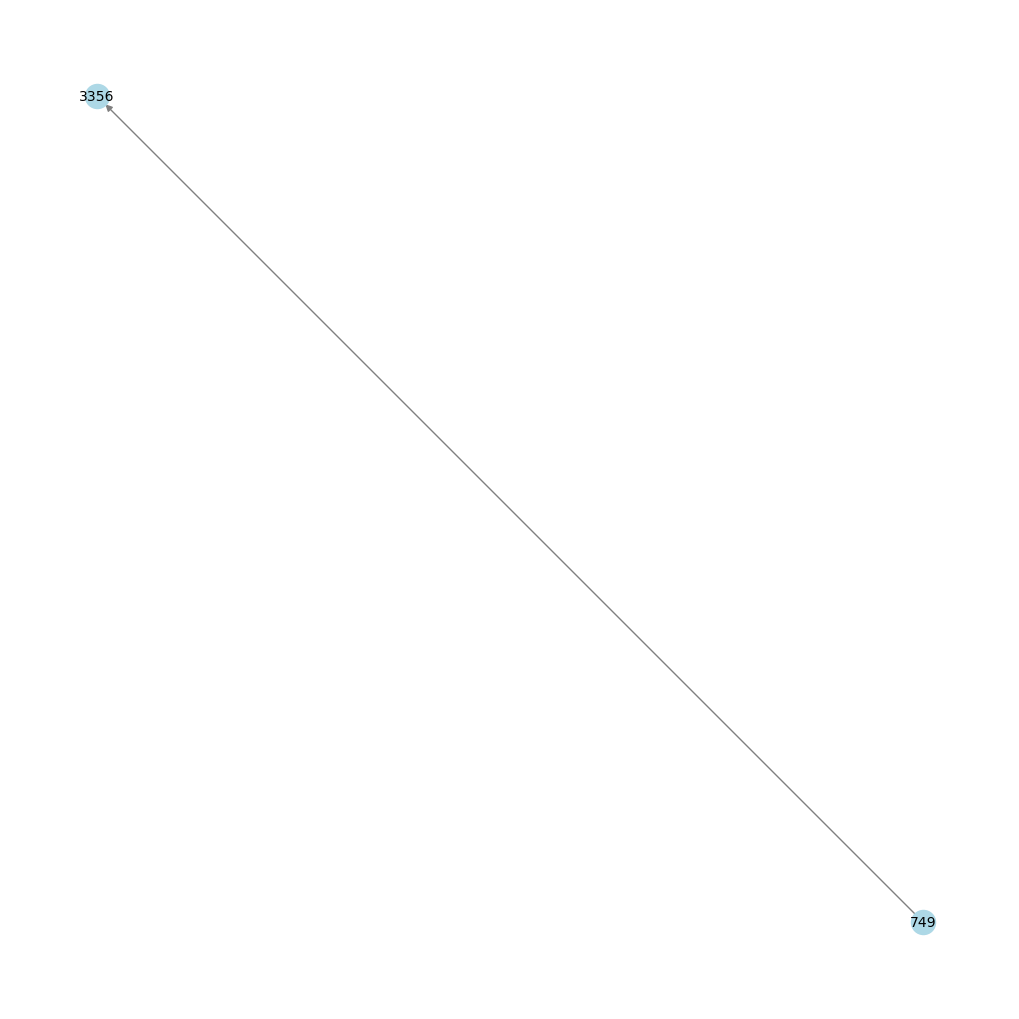

In [5]:
# test use of bgpSubgraph

test = bgpSubgraph("749")
print(test.number_of_nodes())
print(test.number_of_edges())


pos = nx.spring_layout(test, k=0.8)
plt.figure(figsize=(10, 10))
nx.draw(test, pos, with_labels=True, node_color="lightblue", edge_color="gray", font_size=10, arrows=True)
plt.show()

In [15]:
asnLocations = await fetch_until_done(bgpNetwork.nodes())

In [21]:
for key, value in asnLocations.items():
    print(f"{key}: {value}")

25668: (50.2998329453935, -119.128629026216)
58077: (51.07, 19.44)
141355: (36.8, 68.86)
268481: (-21.75, -41.33)
47: (34.0203042069924, -118.27984797984)
270768: (-16.79, -49.95)
45268: (23.73, 90.42)
206118: (51.37, 16.96)
37282: (6.34221434630557, 3.12906326324481)
144730: (0, 0)
197002: (47.733584999233, 34.9992404965955)
272526: (0, 0)
273369: (0, 0)
21566: (41.14, -104.79)
24353: (0, 0)
212405: (32.8, -117.17)
51575: (40.91, 29.16)
199604: (49.65, 17.32)
150354: (-33.9, 151.2)
54714: (39.1728924342382, -103.126669875752)
269331: (-20.28, -45.55)
65539: (None, None)
135240: (13.02, 77.7)
57237: (42.9571234061611, 25.6345717033958)
28534: (19.7960002864657, -98.9571016110404)
145435: (0, 0)
61311: (52.34, 16.93)
142894: (0, 0)
209583: (41.48, 14.05)
133219: (53.3597406450848, 48.4710590087762)
41005: (50.04, 19.92)
55081: (43.5849730348452, -72.9696006825764)
268211: (-5.06666709402986, -42.8033321342302)
146079: (0, 0)
38974: (55.6850406281151, 37.7297574531489)
137602: (28.48, 77

In [25]:
for asn1, asn2 in bgpNetwork.edges():
    lat1, lon1 = asnLocations[asn1]
    lat2, lon2 = asnLocations[asn2]

    if lat1 == None or lat2 == None or lon1 == None or lon2 == None:
        continue

    distance = haversine(lat1, lon1,lat2, lon2)

    bgpNetwork[asn1][asn2]['weight'] = distance
    